In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

In [2]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

In [ ]:
#Importación de archivos de afiliados
inicio = time.time()
afi = pd.read_csv( ruta_afi, delimiter='\t', encoding='iso-8859-1', decimal='.')
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', 
        (fin-inicio)%60, ' segundos' )

In [ ]:
#Agrupamiento por relación de trabajo
inicio = time.time()
agrupa = [ (afi['SECTOR'].isin(['PRIVADO', 'PASANTE PRIVADO'])), 
           (afi['SECTOR'].isin(['PUBLICO', 'PASANTE PUBLICO'])), 
           (afi['SECTOR'].isin(['INDEPENDIENTES', '108-ARTISTA Y GESTOR DE CULTURA', 
                                '02-TRABAJ. AUT Y SIN RELAC DEPEN DESDE  2011-12 SOLO AF.VOLUNT  '])),
           (afi['SECTOR'].isin(['69-VOLUNTARIO ECUATORIANO DOMICILIADO EN EL EXTERIOR ',
                                '89-AFILIACION DOMICILIADO EN EL EXTERIOR'])),
           (afi['SECTOR'] == '90-AFILIACION DOMICILIADO EN EL PAIS / SIN RELACION DEPENDENCIA'),
           (afi['SECTOR'] == '06-CODIGO DEL TRABAJO - CT ')
            ]
            
tipo = ['PRI', 'PUB', 'IND', 'VOL_EX', 'VOL_EC', 'COD_TR']

afi['SECTOR_A'] = np.select( agrupa, tipo, default=afi['SECTOR'])
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', 
        (fin-inicio)%60, ' segundos' )

In [ ]:
afi['SECTOR'].unique()

In [ ]:
afi['SECTOR_A'].unique()

In [ ]:
afi.shape

In [ ]:
#Para acceder a las prestaciones de IVM debe tener al menos 5 años de aporte o 60 imposiciones
ced_counts = afi.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()

In [ ]:
# numero de cedulas que tienen menos de 60 imposiciones
ced_counts[ced_counts < 60].index.nunique()

In [ ]:
#Se filtran a las cedulas con menos de 60 imposicones 
inicio = time.time()
afi_fil = afi[~afi['CEDULA_COD'].isin(ced_counts[ced_counts < 60].index)].copy()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

#Se crea una variable fecha
inicio = time.time()
afi_fil.loc[:, 'FECHA'] = pd.to_datetime(afi_fil['ANIO'].astype(str) + '-' + afi_fil['MES'].astype(str).str.zfill(2) + '-01')
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

#Se ordenan los registros
inicio = time.time()
afi_fil = afi_fil.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, True, True] )
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
afi_fil.shape

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta

# Asegúrate de que el directorio existe
os.makedirs(directorio, exist_ok=True)

# Nombre del archivo
nombre_archivo = 'viu_clean_afi.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = afi

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo)
    
    
# Nombre del archivo
nombre_archivo = 'viu_clean_afi_fil.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto2 = afi_fil

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto2, archivo)

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
# directorio = r_ruta
# nombre_archivo = 'viu_clean_afi_fil.pkl'
# ruta_archivo = os.path.join(directorio, nombre_archivo)

# with open( ruta_archivo, 'rb') as archivo:
#     afi_fil = pickle.load( archivo )    

In [ ]:
#Se eliminan archivos no necesarios para liberar la memoria
del afi
del objeto1
del objeto2
del ced_counts

In [ ]:
afi_fil #Tiene una dimensión de (64638969 rows × 14 columns) 

In [ ]:
#Se seleccionan las características de la población para los año y mes de aportación
afi_sel = afi_fil[['CEDULA_COD', 'ANIO', 'MES', 'FECHA','SALARIO', 'SECTOR_A']].copy()
del afi_fil

In [ ]:
#Inicio de la HL
caract = afi_sel.groupby('CEDULA_COD')['FECHA'].min().reset_index() 
caract.rename( columns={'FECHA': 'INI_HL'}, inplace=True)
#Fin de la HL
caract['FIN_HL'] = caract['CEDULA_COD'].map( afi_sel.groupby('CEDULA_COD')['FECHA'].max() )
#Contar los meses, considerando duplicidad en los meses que puede tener aporte simultaneos
caract['MES_AS'] = caract['CEDULA_COD'].map( afi_sel['CEDULA_COD'].value_counts() )
#Meses trabajados unicos
aux = afi_sel.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])
caract['MES_TU'] = caract['CEDULA_COD'].map( aux['CEDULA_COD'].value_counts() )

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_clean_caract.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto3 = caract

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto3, archivo)    

In [ ]:
del objeto3

In [ ]:
caract

In [ ]:
#Personas que tienen varios aportes simultaneos
caract[caract['MES_AS']>caract['MES_TU']]

In [ ]:
#afi_sel[afi_sel['CEDULA_COD']==21729781].tail(60)

In [ ]:
afi_sel =  afi_sel.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, False, False] )
afi_sel['SALARIO_SECTOR'] = afi_sel['SALARIO']
afi_sel['NUM_SEC_MES'] = 1
afi_sel['%_NUM_SECTOR'] = afi_sel['SALARIO']

In [ ]:
aux = afi_sel[afi_sel.duplicated(subset=['CEDULA_COD', 'ANIO', 'MES'], keep=False)]
aux1 = afi_sel[~afi_sel.duplicated(subset=['CEDULA_COD', 'ANIO', 'MES'], keep=False)]

In [ ]:
aux

In [ ]:
#Se debe analizar a las personas que tienen varios aportes en un mismo mes
#Se suman los salarios y se concatenan los sectores para la cedula que en el mismo anio y mes tienen más de un sector
inicio = time.time()
afi_sel_g = aux.groupby(['CEDULA_COD', 'ANIO', 'MES']).agg({'SALARIO': 'sum',
                                                            'SALARIO_SECTOR': lambda x: ';'.join(x.astype(str)),
                                                            'SECTOR_A': lambda x: ';'.join(x),
                                                            'NUM_SEC_MES': lambda x: len(x),
                                                            '%_NUM_SECTOR': lambda x:  ';'.join((x / x.sum()).round(4).astype(str))
                                                                }).reset_index()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )


In [ ]:
afi_sel_g

In [ ]:
afi_sel_g_all = pd.concat( [aux1[['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR','SECTOR_A', 'NUM_SEC_MES', '%_NUM_SECTOR']], 
                            afi_sel_g], ignore_index=True )

In [ ]:
afi_sel_g_all

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_clean_afi_sel_g_all.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto4 = afi_sel_g_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto4, archivo)      

In [ ]:
#afi_sel_g_all = objetos[3]

In [ ]:
del aux
del aux1
del objeto4

In [ ]:
afi_sel_g_all = afi_sel_g_all.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, False, False] )
afi_sel_g_all.loc[ (afi_sel_g_all['NUM_SEC_MES'] == 1), '%_NUM_SECTOR'] = '1'

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==216]

In [ ]:
#Se reinician los index
afi_sel_g_all.reset_index(inplace=True)
afi_sel_g_all.rename(columns={'index': 'nuevo_indice'}, inplace=True)
afi_sel_g_all.drop(columns=['nuevo_indice'], inplace=True)

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126]

In [ ]:
#se crean los grupos de 12 meses trabajados para tener
n_grupo = 12
afi_sel_g_all['GRUPO'] = (afi_sel_g_all.groupby('CEDULA_COD').cumcount() // n_grupo ) + 1
#Se saca el salario promedio de cada grupo
afi_sel_g_all['SAL_PROM_GRUPO'] = afi_sel_g_all.groupby(['CEDULA_COD', 'GRUPO'])['SALARIO'].transform('mean')

In [ ]:
afi_sel_g_all

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126]['GRUPO'].unique()

In [ ]:
#Se obtienen los sueldos promedios para cada grupo y cada cedula
inicio = time.time()
df1 = afi_sel_g_all.groupby(['CEDULA_COD', 'GRUPO'])['SAL_PROM_GRUPO'].first().reset_index().copy()
df1 = df1.sort_values(by = ['CEDULA_COD','SAL_PROM_GRUPO'], ascending=[True,False])
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
df1

In [ ]:
 df1[df1['CEDULA_COD']==126]

In [ ]:
#Se seleccionan los 5 mejores años de sueldo
inicio = time.time()
top = 5
#top_sal = df1.groupby('CEDULA_COD')['SAL_PROM_GRUPO'].nlargest(top).reset_index(level=0, drop=True)
indices = df1.groupby('CEDULA_COD').apply(lambda x: x.index[:top]).explode()
df2 = df1.loc[indices].reset_index(drop=True)
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
df2[df2['CEDULA_COD']==126]

In [ ]:
#Seleccionar los cinco mejores años del grupo total de años de aporte
combinaciones = set(zip(df2['CEDULA_COD'], df2['GRUPO']))
afi_sel_g_all['GRUPO_SEL'] = [(cedula, grupo) in combinaciones for cedula, grupo in zip(afi_sel_g_all['CEDULA_COD'], afi_sel_g_all['GRUPO'])]
afi_sel_g_all['GRUPO_SEL'] = afi_sel_g_all['GRUPO_SEL'].astype(int)

In [ ]:
#Verificar que todas las cédulas tengan al menos 60 registros de los salarios
ced_counts1 = afi_sel_g_all.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()
ced_counts1[ced_counts1 < 60].index.nunique()

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126].tail(60)

In [ ]:
#Se crea una variable fecha para el período de mejores años y la base de cálculo
inicio = time.time()
mejores = afi_sel_g_all[afi_sel_g_all['GRUPO_SEL']==1].copy()
mejores.loc[:, 'FECHA'] = pd.to_datetime(mejores['ANIO'].astype(str) + '-' + mejores['MES'].astype(str).str.zfill(2) + '-01')

#Se calcula la base de calculo
df_prom = mejores.groupby('CEDULA_COD')['SALARIO'].mean()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
mejores

In [ ]:
afi_sel_g_all['INI_CAL'] = afi_sel_g_all['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].max() )
afi_sel_g_all['FIN_CAL'] = afi_sel_g_all['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].min() )
afi_sel_g_all['BASE_CAL'] = afi_sel_g_all['CEDULA_COD'].map( df_prom )

In [ ]:
caract['INI_CAL'] = caract['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].max() )
caract['FIN_CAL'] = caract['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].min() )
caract['BASE_CAL'] = caract['CEDULA_COD'].map( df_prom )
caract

In [ ]:
del df1, df2, mejores

In [ ]:
afi_sel_g_all[ (afi_sel_g_all['CEDULA_COD']==126) & (afi_sel_g_all['GRUPO_SEL']==1)]['SALARIO'].mean()

In [ ]:
afi_sel_g_all[ (afi_sel_g_all['CEDULA_COD']==126)]

In [ ]:
# #     df = asignar_grupo(sect, n_grupo)
# #     df1 = valores_unicos_grupos(df)
# #     df2 = sel_top_salarios(df1, top)
# #     df = sel_grupo(df, df2)
#     df = fec_sel_grupo(df)
#     df = base_cal(df)
#     df = ati_base_cal_m1(df, inferior)
#     df = base_cal_sin_ati_m1(df)
#     df = sbu_ajuste_m1(df, SBU)

In [ ]:
#Registros con años menores al 2000
afi_sel_g_all[afi_sel_g_all['FIN_CAL'].dt.year<2000]

In [ ]:
#Se agrega el valor del SBU
SBU = pd.DataFrame( { 'ANIO':[2000,2001,2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
                              2021, 2022, 2023, 2024],
                      'VALOR':[57,85.65,105, 122, 136, 150, 160, 170, 200, 218, 240, 264, 292, 318, 340, 354, 366, 375, 386, 394, 400, 
                              400, 425, 450, 460]})
SBU

In [ ]:
afi_sel_g_all['SBU'] = afi_sel_g_all['ANIO'].map( SBU.groupby('ANIO')['VALOR'].first())

In [ ]:
afi_sel_g_all

In [ ]:
#Cédula que tienen su historia laboral igual al SBU
afi_sel_g_all['ID_SBU'] = afi_sel_g_all['SALARIO'] == afi_sel_g_all['SBU']
#Si tiene -1 es un valor que no es un SBU en ese año y mes
afi_sel_g_all['ID_SBU'] = afi_sel_g_all['ID_SBU'].astype(int)-1
afi_sel_g_all

In [ ]:
#Verificar que todas las cédulas tengan 60 registros
ced_counts2 = afi_sel_g_all.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()
ced_counts2[ced_counts2 < 60].index.nunique()

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126].shape

In [ ]:
afi_sel_g_all[(afi_sel_g_all['CEDULA_COD']==126) & (afi_sel_g_all['GRUPO_SEL']==1)]

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto5 = afi_sel_g_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto5, archivo)      

del objeto 5

In [ ]:
objeto5

In [ ]:
#Selección de cedulas con sus mejores años de sueldo y que su salario no sea un SBU
data_sin_ati = afi_sel_g_all[ (afi_sel_g_all['GRUPO_SEL']==1) & (afi_sel_g_all['ID_SBU']!=-1)]
data_ati = afi_sel_g_all[ (afi_sel_g_all['GRUPO_SEL']==1) & (afi_sel_g_all['ID_SBU']!=0)]

In [ ]:
data_ati.shape #(21022610, 15)
data_sin_ati.shape #(5449506, 15)

In [ ]:
data_ati[data_ati['CEDULA_COD']==126][['CEDULA_COD','ANIO','MES','SALARIO']].shape

In [ ]:
data_ati[data_ati['CEDULA_COD']==126]

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_clean_data_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto6 = data_ati

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto6, archivo)         

# Nombre del archivo
nombre_archivo = 'viu_clean_data_sin_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto7 = data_sin_ati

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto7, archivo)     
    
del objeto6, objeto7

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo )     

In [ ]:
#Análisis de atípicos
#Método de clustering jerárquico
# data_l = afi_sel_g_all.copy()
data_l.shape #(62130167, 16)

In [ ]:
# del objeto5,  afi_sel_g_all
# gc.collect()

In [ ]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['ATI_CJ_M1'] = np.nan
data_no_grupo['ATI_CJ_M2'] = np.nan
data_no_grupo['ATI_CJ_M3'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )


In [11]:
#Para ejecutar el cluster jerarquico
def cluster_jerarquico( data_si_dic, k):
    inicio = time.time()
    nom = 'ATI_CJ_M' + str( k+1 )
    data_val_ati = {}
    for cedula in data_si_dic:

        if( len( data_si_dic[ cedula ]['SALARIO'] ) > 1 ): #Para formar al menos un cluster

            aux = np.array( data_si_dic[ cedula ]['SALARIO'] ).reshape(-1, 1)
            Z = linkage( aux , method='single', metric='euclidean')

            num_clusters = 2  # Puedes ajustar este valor según tus necesidades
            clusters = fcluster(Z, num_clusters, criterion='maxclust')

            if( len( np.unique(clusters) ) > 1 ): #Para considerar al menos 2 cluster
                # Calcular el centroide de cada clúster
                cluster_centers = np.array([[ np.nanmean(aux[clusters == i], axis=0)[0], i ] for i in range(1, num_clusters + 1)] ) 

                Q1 = np.quantile(aux, 0.25)
                Q3 = np.quantile(aux, 0.75)
                IQR = Q3-Q1
                LI = Q1 - 1.5 * IQR
                LS = Q3 + 1.5 * IQR

                cl_at = np.where( cluster_centers[:,0] > (LS +  1e-8) )[0]
                cluster_centers[cl_at][:, 1]

                mod_aux = np.zeros((len(aux), 2))
                mod_aux[:, 0] = aux[:, 0]  # Copiar los valores originales de aux en la primera columna
                mod_aux[np.isin(clusters, cluster_centers[cl_at][:, 1]), 1] = 1  # Asignar 1 en la segunda columna donde el cluster es 1

                data_val_ati[cedula] = {'SALARIO': mod_aux[:, 0].tolist(),
                                             nom : mod_aux[:, 1].tolist(),
                                        'INDICE' : data_si_dic[ cedula ]['INDICE']}
            else:
                data_val_ati[cedula] = { 'SALARIO': aux.flatten().tolist(),
                                               nom:  [-1] * len(aux),
                                         'INDICE' : data_si_dic[ cedula ]['INDICE']} 

        else:
            data_val_ati[cedula] = { 'SALARIO': data_si_dic[ cedula ]['SALARIO'],
                                           nom:  [-2] * len( data_si_dic[ cedula ]['SALARIO'] ),
                                     'INDICE' : data_si_dic[ cedula ]['INDICE']}
    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    
    return data_val_ati
 
#Para unir los resultados
def extend_data( data_val_ati, k ):
    inicio = time.time()
    nom = 'ATI_CJ_M' + str( k + 1 )
    data1 = { 'CEDULA_COD': [], 'SALARIO': [], nom : [], 'INDICE':[]}

    # Llenar las listas con los datos del diccionario
    for cedula, values in data_val_ati.items():
        salario = values['SALARIO']
        atipico = values[ nom ]
        indice = values['INDICE']
        num_rows = len(salario)

        # Extender las listas en el diccionario de datos
        data1['CEDULA_COD'].extend([cedula] * num_rows)
        data1['SALARIO'].extend(salario)
        data1[ nom ].extend(atipico)
        data1['INDICE'].extend(indice)

    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    return data1

#Para graficar el comportamiento de los atipicos
def graf_ati(ced, k):
    nom = 'ATI_CJ_M'+ str(k)
    dt = data_l[(data_l['GRUPO_SEL']==1) & (data_l['CEDULA_COD']==ced)]
    unique_ati = dt[ nom ].nunique(dropna=False)
    categories = dt[ nom ].unique()

    # Generar una lista de colores discretos
    colors = plt.cm.coolwarm(np.linspace(0, 1, unique_ati))

    # Crear un mapa de colores discreto
    cmap = ListedColormap(colors)

    # Graficar
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(dt.index, dt['SALARIO'], c=dt[ nom ], cmap=cmap)

    plt.xlabel('Index')
    plt.ylabel('Salario')
    plt.title('Gráfico de Salario')

    # Crear una leyenda discreta personalizada
    # Definir las etiquetas para cada categoría
    labels = { 0: 'No es atípico', 1: 'Es atípico', -1: 'Es un solo clúter', -2:'No forma parte del proceso',
               np.nan: 'Valor NA'}

    # Crear los handles para la leyenda
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markersize=10, markerfacecolor=cmap(i), 
                          label=labels[i]) for i in categories]

    plt.legend(handles=handles, title='Tipo de Salario')
    plt.show()

In [ ]:
data[ ~(( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ]

In [ ]:
#Se crea un bucle para cada caso
for k in range(0,3):
    nom = 'ATI_CJ_M' + str( k+1 )
    if (k==0):
        ##Primer Caso--Considerando solo los salarios mayores al SBU y desde el año 2000
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data[   (( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ].copy() 
        data_no = data[ ~(( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ].copy() 
        data_no[ nom ] = np.nan
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) #(26006294, 16)
        print('Tamaño de la data no utilizada dentro de los años seleccionados',data_no.shape)  #(465822, 16)
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        data_no_dic = data_no.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO',  nom , 'INDICE']],
                                  pd.DataFrame( data1 ), 
                                  data_no[['CEDULA_COD', 'SALARIO',  nom , 'INDICE']] ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom )] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif1 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')  
        
    if (k==1):
        ##Segundo Caso--Considerando todo el registro de los mejores años
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data.copy()
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) 
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', nom, 'INDICE']],
                                  pd.DataFrame( data1 ) ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom ) ] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif2 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')
        
    if (k==2):
        ##Tercer Caso--Considerando todo el registro de los mejores años, pero a partir del año 2000
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data[  ( ( data['ANIO'] >= 2000 )) ].copy()
        data_no = data[ ~( ( data['ANIO'] >= 2000 )) ].copy()   
        data_no[ nom ] = np.nan
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) 
        print('Tamaño de la data no utilizada dentro de los años seleccionados',data_no.shape) 
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        data_no_dic = data_no.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', nom, 'INDICE']],
                                  pd.DataFrame( data1 ), 
                                  data_no[['CEDULA_COD', 'SALARIO', nom, 'INDICE']] ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom )] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif3 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')



        

In [ ]:
del data, data_jerar, data1, aux, data_si, data_no, data_no_grupo, data_val_ati
gc.collect()

In [ ]:
#Se calculan los limítes máximos de aportación en función de la HL
#Caso 1: Para toda la historia laboral
inicio = time.time()   
grupo1 = data_l.copy()
Q1 = grupo1.groupby('CEDULA_COD')['SALARIO'].quantile(0.25)
Q3 = grupo1.groupby('CEDULA_COD')['SALARIO'].quantile(0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
data_l['LS1'] = data_l['CEDULA_COD'].map( LS )

#Caso 2: Para la historia laboral a partir del año 2020
grupo2 = data_l[ data_l['ANIO']>=2000 ].copy()
Q1 = grupo2.groupby('CEDULA_COD')['SALARIO'].quantile(0.25)
Q3 = grupo2.groupby('CEDULA_COD')['SALARIO'].quantile(0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
data_l['LS2'] = data_l['CEDULA_COD'].map( LS )

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos')

del grupo1, grupo2, Q1, Q3, IQR, LI, LS
gc.collect()

In [ ]:
#El valor de NA implica que esos datos no son parte de data_si, por lo que no se analizaron
#El valor de -1 implica que se formó un solo cluster
#El valor de -2 implica que en la selección de datos (data_si), la cedula solo tenía un único valor para formar los cluster
# pues era el resultado de filtrar el data_si

##Se analiza el caso de los valores de atipicos del método 1
# data_l[ ( data_l['GRUPO_SEL']==1 )]['ATI_CJ_M1'].unique() #array([ 0., nan,  1., -1., -2.])
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1']==-2)] #86 rows × 21 columns
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1'].isna())]  #465822 rows × 21 columns
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1']==-1)]  # 3292785 rows × 21 columns

##Se analiza el caso de los valores de atipicos del método 2
# data_l[ ( data_l['GRUPO_SEL']==1 )]['ATI_CJ_M2'].unique() #rray([ 0.,  1., -1.])
# ata_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M2']==-1)]  #3125765 rows × 21 columns

##Se analiza el caso de los valores de atipicos del método 3
# data_l[ ( data_l['GRUPO_SEL']==1 )]['ATI_CJ_M3'].unique() #array([ 0.,  1., -1., nan, -2.])
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3']==-2)] #2 rows × 21 columns
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3'].isna())]  # 7454 rows × 21 columns
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3']==-1)] #3125140 rows × 21 columns

In [ ]:
#Cedulas que tiene datos atípicos----------------------------------------------------------------------------------------------
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique()) #134017
print('\tCedulas con valor -2:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2)]['CEDULA_COD'].nunique()) #86
print('\tCedulas con valor nan:',           data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna())]['CEDULA_COD'].nunique()) #85804
print('\tCedulas con valor -1:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1)]['CEDULA_COD'].nunique()) #55669
print('\tCedulas con valor 0:',             data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==0)]['CEDULA_COD'].nunique()) #379216
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==1)]['CEDULA_COD'].nunique()) #123850
print('\tCedulas con valor -2:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-2)]['CEDULA_COD'].nunique()) #0
print('\tCedulas con valor nan:',           data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2'].isna())]['CEDULA_COD'].nunique()) #0
print('\tCedulas con valor -1:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1)]['CEDULA_COD'].nunique()) #52121
print('\tCedulas con valor 0:',             data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==0)]['CEDULA_COD'].nunique()) #383682
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==1)]['CEDULA_COD'].nunique()) #123826
print('\tCedulas con valor -2:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2)]['CEDULA_COD'].nunique()) #2
print('\tCedulas con valor nan:',           data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna())]['CEDULA_COD'].nunique()) #499
print('\tCedulas con valor -1:',            data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1)]['CEDULA_COD'].nunique()) # 52124
print('\tCedulas con valor 0:',             data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==0)]['CEDULA_COD'].nunique()) #383653
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)

In [ ]:
graf_ati(23075971, 1)

In [ ]:
#Caso 1- Correcciones---------------------------------------------------------------------------------------------------
#Se corrige en función deL Límite máximo de la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] > data_l['LS2']) ), 'ATI_CJ_M1'] = 1 #quedan 45 casos
#Se corrige en función del valores menoRes al limite máximo la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] <= data_l['LS2']) ), 'ATI_CJ_M1'] = 0 
# Se hacen las correcciones para los valores -2, en donde si el Salario es menor o igual a un SBU no es atípico( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0 

#Se corrige en función deL Límite máximo de toda la HL, pues si no hay datos del SBU para atrás ( NA -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M1'] = 1  #quedan 463235 casos
#Se corrige en función del valores menoRes al limite máximo la HL, pues si no hay datos del SBU para atrás ( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M1'] = 0  #
#Se hacen las correcciones para los valores NA, en donde si el Salario es menor o igual a un SBU no es atípico( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0  

#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M1'] = 1 #quedan 3267088
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M1'] = 0 #q 
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0 #

#Se hacen las correcciones para los valores 1, en donde si el Salario es menor o igual al SBU no es atípico( 1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0

In [ ]:
#Caso 2 - Correcciones---------------------------------------------------------------------------------------------------
#No existen valores igual a NA e igual a -2
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M2'] = 1 # quedan 3104185
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M2'] = 0
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M2'] = 0 
#Se hacen las correcciones para los valores 1, en donde si el Salario es menor o igual al SBU no es atípico( 1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M2'] = 0

In [ ]:
#Caso 3 - Correcciones-------------------------------------------------------------------------------------------------
#Se corrige en función deL Límite máximo de la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] > data_l['LS2']) ), 'ATI_CJ_M3'] = 1 # quedan 2 casos
#Se corrige en función del valores menores al limite máximo la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] <= data_l['LS2']) ), 'ATI_CJ_M3'] = 0
#Se hacen las correcciones para los valores -2, en donde si el Salario es menor o igual a un SBU no es atípico( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 #

#Se corrige en función deL Límite máximo de toda la HL, pues si no hay datos del SBU para atrás ( NA -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M3'] = 1 #quedan 7394 casos
#Se corrige en función del valores menoRes al limite máximo la HL, pues sno hay datos del SBU para atrás ( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M3'] = 0  
#Se hacen las correcciones para los valores NA, en donde si el Salario es menor o igual a un SBU no es atípico( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 

#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M3'] = 1 #quedan 3103457  casos
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M3'] = 0
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 
#Se hacen las correcciones para los valores 1, en donde si el Salario es menor o igual al SBU no es atípico( 1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0

In [ ]:
graf_ati(23075971, 1)

In [ ]:
#Cedulas que tiene datos atípicos----------------------------------------------------------------------------------------------
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique()) #125237
print('\tCedulas con sin atípicos:',        data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==0)]['CEDULA_COD'].nunique()) #436149
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==1)]['CEDULA_COD'].nunique()) #116931
print('\tCedulas con sin atípicos:',        data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==0)]['CEDULA_COD'].nunique()) #436148
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con al menos un atípico:', data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==1)]['CEDULA_COD'].nunique()) #116938
print('\tCedulas con sin atípicos:',        data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==0)]['CEDULA_COD'].nunique()) #436149
print('*' * 102)

In [ ]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_clean_data_l.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto8 = data_l

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto8, archivo)      

del objeto8

In [4]:
data_l.shape

(62130167, 22)

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_data_l.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo )     

In [5]:
#Analisis para atípicos vs aportes simultáneos
cedula_1 = data_l.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data_l[ ~data_l['CEDULA_COD'].isin( cedula_dist )]
ml = data_l[  data_l['CEDULA_COD'].isin( cedula_dist )]

#Cedulas que tiene datos atípicos----------------------------------------------------------------------------------------------
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      ul[ (ul['GRUPO_SEL']==1) & (ul['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique())
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      ul[ (ul['GRUPO_SEL']==1) & (ul['ATI_CJ_M2']==1)]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M2']==1)]['CEDULA_COD'].nunique())
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      ul[ (ul['GRUPO_SEL']==1) & (ul['ATI_CJ_M3']==1)]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M3']==1)]['CEDULA_COD'].nunique())
print('*' * 102)


************************************************** Caso  1 **************************************************
	Cedulas con al menos un atípico con un único sector: 77175
	Cedulas con al menos un atípico con más de un único sector: 48062
************************************************** Caso  2 **************************************************
	Cedulas con al menos un atípico con un único sector: 72182
	Cedulas con al menos un atípico con más de un único sector: 44749
************************************************** Caso  3 **************************************************
	Cedulas con al menos un atípico con un único sector: 72185
	Cedulas con al menos un atípico con más de un único sector: 44753
******************************************************************************************************


In [6]:
#Creando limites de atipicos
inicio = time.time()   
#Caso 3: Para toda la historia laboral sin considerar aportes simultáneos
# cedula_1 = data_l.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
# cedula_dist = cedula_1[ cedula_1 ].index
# grupo3 = data_l[ ~data_l['CEDULA_COD'].isin( cedula_dist )]
grupo3 = ul

Q1 = grupo3.groupby('CEDULA_COD')['SALARIO'].quantile(0.25)
Q3 = grupo3.groupby('CEDULA_COD')['SALARIO'].quantile(0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
data_l['LS3'] = data_l['CEDULA_COD'].map( LS )

#Caso 4: Para toda la historia laboral considerando aportes simultáneos
#grupo4 = data_l[ data_l['CEDULA_COD'].isin( cedula_dist )]
grupo4 = ml
dic_aux = grupo4.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [] }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l['LS4'] = data_l['CEDULA_COD'].map( LS )  

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos')

del grupo3, grupo4, dic_aux, data1, Q1, Q3, IQR, LI, LS
gc.collect()

	Tiempo de ejecución es:  0.0  horas con  1.0  minutos y 13.084720373153687  segundos


0

In [7]:
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==1) ]['CEDULA_COD'].unique()

array([     397,      472,     1073, ..., 21035240, 21104059, 21729781],
      dtype=int64)

In [8]:
data_l[ (data_l['GRUPO_SEL']==1) & (data_l['CEDULA_COD']==397)]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,SBU,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2,LS3,LS4
1104,397,2007,2,448.96,448.96,PUB,1,1,5,510.380833,...,170.0,-1,1104,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1105,397,2007,3,448.96,448.96,PUB,1,1,5,510.380833,...,170.0,-1,1105,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1106,397,2007,4,448.96,448.96,PUB,1,1,5,510.380833,...,170.0,-1,1106,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1107,397,2007,5,448.96,448.96,PUB,1,1,5,510.380833,...,170.0,-1,1107,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1108,397,2007,6,448.96,448.96,PUB,1,1,5,510.380833,...,170.0,-1,1108,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1109,397,2007,7,488.94,488.94,PUB,1,1,5,510.380833,...,170.0,-1,1109,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1110,397,2007,8,488.94,488.94,PUB,1,1,5,510.380833,...,170.0,-1,1110,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1111,397,2007,9,728.81,728.81,PUB,1,1,5,510.380833,...,170.0,-1,1111,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1112,397,2007,10,543.27,543.27,PUB,1,1,5,510.380833,...,170.0,-1,1112,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56
1113,397,2007,11,543.27,543.27,PUB,1,1,5,510.380833,...,170.0,-1,1113,0.0,0.0,0.0,3282.6475,3282.6475,NaN,1326.56


In [9]:
del ul, ml
gc.collect()

0

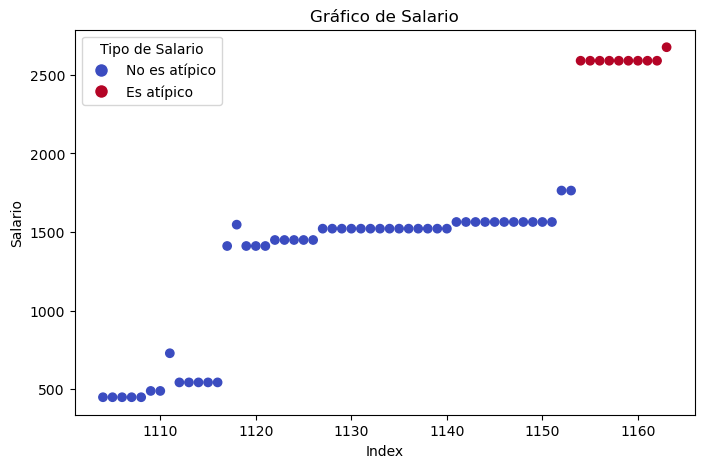

In [12]:
graf_ati(397, 1)

In [13]:
data_l['ATI_CJ_AS'] = 0
grupo1 = None
grupo1 = data_l[  data_l['CEDULA_COD'].isin( cedula_dist )].copy() #Es igual a ml pero se actualizan los valores

inicio = time.time()   
dic_sim = grupo1.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'LS4': list,'INDICE': list}).to_dict(orient='index')

for cedula in dic_sim:
    dic_sim[cedula]['SALARIO_SECTOR'] = [[float(val) for val in sal.split(';')] if isinstance(sal, str) else [sal] 
                                          for sal in dic_sim[cedula]['SALARIO_SECTOR']]
    dic_sim[cedula]['ATI_CJ_AS'] = [ 1 if any(sal > ls for sal in salarios) else 0 
                                    for salarios, ls in zip( dic_sim[cedula]['SALARIO_SECTOR'], dic_sim[cedula]['LS4'])]

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos')

del grupo1   
gc.collect()

	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 39.130115270614624  segundos


0

In [16]:
data1 = { 'CEDULA_COD': [], 'SALARIO_SECTOR': [], 
         'LS4' : [], 'ATI_CJ_AS':[],  'INDICE':[]}

# Llenar las listas con los datos del diccionario
for cedula, values in dic_sim.items():
    salario = values['SALARIO_SECTOR']
    ls = values[ 'LS4' ]
    atipico = values[ 'ATI_CJ_AS' ]
    indice = values['INDICE']
    num_rows = len(salario)

    # Extender las listas en el diccionario de datos
    data1['CEDULA_COD'].extend([cedula] * num_rows)
    data1['SALARIO_SECTOR'].extend(salario)
    data1['LS4' ].extend(ls)
    data1['ATI_CJ_AS' ].extend(atipico)
    data1['INDICE'].extend(indice)
    
data1 = pd.DataFrame( data1 )
data1.set_index('INDICE', inplace=True )
data1

,CEDULA_COD,SALARIO_SECTOR,LS4,ATI_CJ_AS
INDICE,,,,
136,216,[282.95],793.735,0
137,216,[282.95],793.735,0
138,216,"[282.95, 168.68]",793.735,0
139,216,"[282.95, 168.68]",793.735,0
140,216,"[168.68, 282.95]",793.735,0
...,...,...,...,...
62129759,21729781,[394.0],508.000,0
62129760,21729781,[394.0],508.000,0
62129761,21729781,[394.0],508.000,0


In [28]:
inicio = time.time()   
cedulas = list(dic_sim.keys())  #total de 111903
filtro = data1[ data1['CEDULA_COD'].isin(cedulas )] # 111903 cedulas
indi = filtro.index
data_l.loc[ indi, 'ATI_CJ_AS'] = filtro['ATI_CJ_AS']

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos')

	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 2.0048775672912598  segundos


In [40]:
sal=[[float(val) for val in sal.split(';')] if isinstance(sal, str) else [sal] for sal in data_l[data_l['CEDULA_COD']==216]['SALARIO_SECTOR']]
sala=[salario for sublist in sal for salario in sublist]
LS = np.percentile(sala, 75) + 1.5 * (np.percentile(sala, 75)-np.percentile(sala, 25))
LS

793.735

In [41]:
data_l[data_l['CEDULA_COD']==216].head(60)

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2,LS3,LS4,ATI_CJ_AS
136,216,2004,7,282.95,282.95,PUB,1,1,6,339.176667,...,-1,136,NaN,NaN,NaN,835.035,835.035,NaN,793.735,0
137,216,2004,8,282.95,282.95,PUB,1,1,6,339.176667,...,-1,137,NaN,NaN,NaN,835.035,835.035,NaN,793.735,0
138,216,2004,9,451.63,282.95;168.68,PUB;PRI,2,0.6265;0.3735,6,339.176667,...,-1,138,NaN,NaN,NaN,835.035,835.035,NaN,793.735,0
139,216,2004,10,451.63,282.95;168.68,PUB;PRI,2,0.6265;0.3735,5,494.748333,...,-1,139,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
140,216,2004,11,451.63,168.68;282.95,PRI;PUB,2,0.3735;0.6265,5,494.748333,...,-1,140,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
141,216,2004,12,451.63,282.95;168.68,PUB;PRI,2,0.6265;0.3735,5,494.748333,...,-1,141,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
142,216,2005,1,487.94,311.26;176.68,PUB;PRI,2,0.6379;0.3621,5,494.748333,...,-1,142,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
143,216,2005,2,508.68,332.0;176.68,PUB;PRI,2,0.6527;0.3473,5,494.748333,...,-1,143,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
144,216,2005,3,512.21,332.0;180.21,PUB;PRI,2,0.6482;0.3518,5,494.748333,...,-1,144,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0
145,216,2005,4,512.21,180.21;332.0,PRI;PUB,2,0.3518;0.6482,5,494.748333,...,-1,145,0.0,0.0,0.0,835.035,835.035,NaN,793.735,0


In [32]:
data1[data1['CEDULA_COD']==216].head(60)

,CEDULA_COD,SALARIO_SECTOR,LS4,ATI_CJ_AS
INDICE,,,,
136,216,[282.95],793.735,0
137,216,[282.95],793.735,0
138,216,"[282.95, 168.68]",793.735,0
139,216,"[282.95, 168.68]",793.735,0
140,216,"[168.68, 282.95]",793.735,0
141,216,"[282.95, 168.68]",793.735,0
142,216,"[311.26, 176.68]",793.735,0
143,216,"[332.0, 176.68]",793.735,0
144,216,"[332.0, 180.21]",793.735,0


In [46]:
ml = data_l[  data_l['CEDULA_COD'].isin( cedula_dist )].copy()
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas que tienen más de un sector y que fue clasificado como atípico, que se modificaran a no atipico:',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==1) & ( ml['ATI_CJ_AS']==0)]['CEDULA_COD'].nunique()) #29408
print('\tCedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==0) & ( ml['ATI_CJ_AS']==1)]['CEDULA_COD'].nunique()) #24171

print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas que tienen más de un sector y que fue clasificado como atípico, que se modificarann a no atipico:',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M2']==1) & ( ml['ATI_CJ_AS']==0)]['CEDULA_COD'].nunique()) #26929
print('\tCedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M2']==0) & ( ml['ATI_CJ_AS']==1)]['CEDULA_COD'].nunique()) #24893

print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas que tienen más de un sector y que fue clasificado como atípico, que se modificarann a no atipico:',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M3']==1) & ( ml['ATI_CJ_AS']==0)]['CEDULA_COD'].nunique()) #26933
print('\tCedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico',
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M3']==0) & ( ml['ATI_CJ_AS']==1)]['CEDULA_COD'].nunique()) #24893
print('*' * 102)

************************************************** Caso  1 **************************************************
	Cedulas que tienen más de un sector y que fue clasificado como atípico, que se modificaran a no atipico: 29408
	Cedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico 24171
************************************************** Caso  2 **************************************************
	Cedulas que tienen más de un sector y que fue clasificado como atípico, que se modificarann a no atipico: 26929
	Cedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico 24893
************************************************** Caso  3 **************************************************
	Cedulas que tienen más de un sector y que fue clasificado como atípico, que se modificarann a no atipico: 26933
	Cedulas que tienen más de un sector y que fue clasificado como  no atípico, que se modificaran a atipico 24

In [49]:
#Cedulas que tiene varios sectores que se modificaran ( 1 -> 0 )
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==1) & ( ml['ATI_CJ_AS']==0)]['CEDULA_COD'].unique() #29408

array([    1908,     2355,     2367, ..., 20876738, 20889949, 21729781],
      dtype=int64)

In [51]:
#Cedulas que tiene varios sectores que se modificaran ( 0 -> 1 )
ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==0) & ( ml['ATI_CJ_AS']==1)]['CEDULA_COD'].unique() #24171

array([     461,      472,      591, ..., 20856839, 20949683, 21104059],
      dtype=int64)

In [52]:
ml[ (ml['GRUPO_SEL']==1) & (ml['CEDULA_COD']==1908)]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2,LS3,LS4,ATI_CJ_AS
13155,1908,2005,7,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13155,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13156,1908,2005,8,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13156,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13157,1908,2005,9,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13157,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13158,1908,2005,10,2518.75,2518.75,PRI,1,1,5,1705.895833,...,-1,13158,1.0,1.0,1.0,2177.0,2177.0,NaN,3753.0,0
13159,1908,2005,11,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13159,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13160,1908,2005,12,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13160,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13161,1908,2006,1,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13161,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13162,1908,2006,2,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13162,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13163,1908,2006,3,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13163,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0
13164,1908,2006,4,1632.00,1632.0,PRI,1,1,5,1705.895833,...,-1,13164,0.0,0.0,0.0,2177.0,2177.0,NaN,3753.0,0


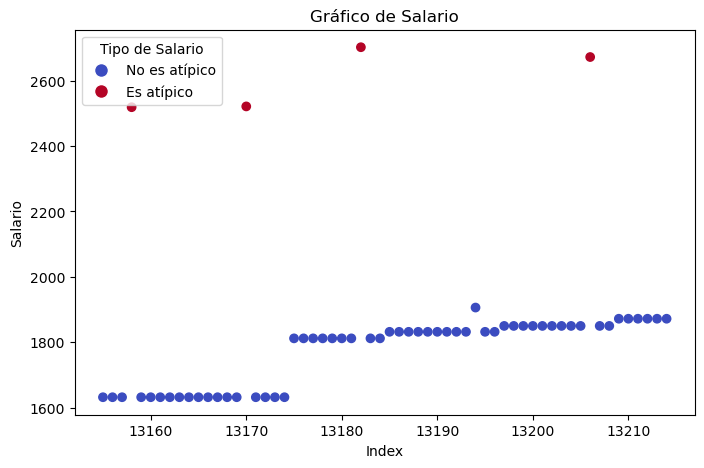

In [53]:
#Gráficas para cuando de 1->0 en aportes simultáneos
graf_ati(1908, 1)

In [54]:
#Gráficas para cuando de 0->1 en aportes simultáneos
ml[ (ml['GRUPO_SEL']==1) & (ml['CEDULA_COD']==472)]

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2,LS3,LS4,ATI_CJ_AS
2307,472,2007,2,1383.04,833.04;550.0,PRI;PUB,2,0.6023;0.3977,5,1400.666667,...,-1,2307,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2308,472,2007,3,1383.04,550.0;833.04,PUB;PRI,2,0.3977;0.6023,5,1400.666667,...,-1,2308,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2309,472,2007,4,1383.04,550.0;833.04,PUB;PRI,2,0.3977;0.6023,5,1400.666667,...,-1,2309,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2310,472,2007,5,1383.04,550.0;833.04,PUB;PRI,2,0.3977;0.6023,5,1400.666667,...,-1,2310,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2311,472,2007,6,1383.04,550.0;833.04,PUB;PRI,2,0.3977;0.6023,5,1400.666667,...,-1,2311,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2312,472,2007,7,1398.34,565.3;833.04,PUB;PRI,2,0.4043;0.5957,5,1400.666667,...,-1,2312,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2313,472,2007,8,1383.04,833.04;550.0,PRI;PUB,2,0.6023;0.3977,5,1400.666667,...,-1,2313,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2314,472,2007,9,1383.04,833.04;550.0,PRI;PUB,2,0.6023;0.3977,5,1400.666667,...,-1,2314,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2315,472,2007,10,1340.32,790.32;550.0,PRI;PUB,2,0.5897;0.4103,5,1400.666667,...,-1,2315,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0
2316,472,2007,11,1462.72,790.32;672.4,PRI;PUB,2,0.5403;0.4597,5,1400.666667,...,-1,2316,0.0,0.0,0.0,2558.635,2558.635,NaN,1241.36,0


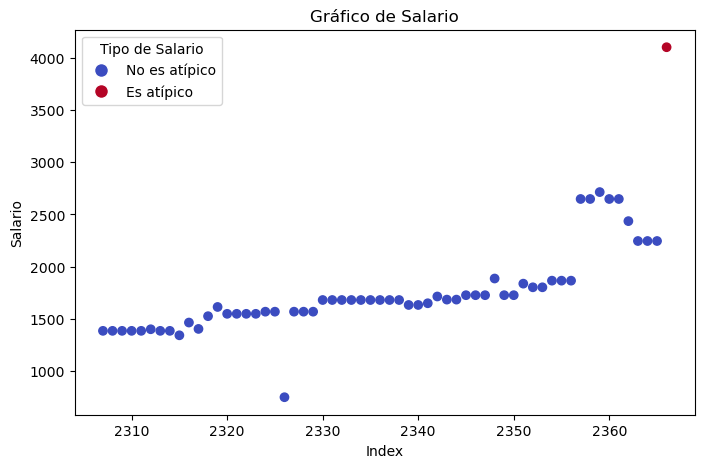

In [55]:
#Gráficas para cuando de 0 -> 1 en aportes simultáneos
graf_ati(472, 1)

In [58]:
cedula_dist 

Int64Index([     216,      397,      461,      472,      506,      554,
                 591,      621,      640,      678,
            ...
            20857129, 20858175, 20876738, 20889304, 20889949, 20949683,
            21035240, 21035907, 21104059, 21729781],
           dtype='int64', name='CEDULA_COD', length=111903)

In [59]:
#Se hacen las correcciones
#Caso 1
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M1'] == 1) & (data_l['ATI_CJ_AS'] == 0), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M1'] == 0) & (data_l['ATI_CJ_AS'] == 1), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']

#Caso 2
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M2'] == 1) & (data_l['ATI_CJ_AS'] == 0), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M2'] == 0) & (data_l['ATI_CJ_AS'] == 1), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']

#Caso 3
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M3'] == 1) & (data_l['ATI_CJ_AS'] == 0), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']
data_l.loc[(data_l['CEDULA_COD'].isin(cedula_dist)) & 
           (data_l['GRUPO_SEL'] == 1) & (data_l['ATI_CJ_M3'] == 0) & (data_l['ATI_CJ_AS'] == 1), 'ATI_CJ_M1'] = data_l['ATI_CJ_AS']


In [ ]:
# data_l[ (data_l['GRUPO_SEL']==1) & (data_l['CEDULA_COD']==397)][['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR',
#                                                                'SECTOR_A', 'NUM_SEC_MES', 'GRUPO_SEL', 'GRUPO', 'ATI_CJ_M1',
#                                                                 'ATI_CJ_M2','ATI_CJ_M3','LS1','LS2','LS3','LS4','ATI_CJ_AS']]

In [ ]:
del data1, dic_sim, filtro, indi, cedulas, ml
gc.collect()

In [61]:
#Cedulas que tiene datos atípicos luego de la corrección---------------------------------------------------------------------
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1) &(~data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1) & (data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique())
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==1) &(~data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==1) &(data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique())
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con al menos un atípico con un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==1) &(~data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique()) 
print('\tCedulas con al menos un atípico con más de un único sector:',
      data_l[ (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==1) &(data_l['CEDULA_COD'].isin(cedula_dist))]['CEDULA_COD'].nunique())
print('*' * 102)

************************************************** Caso  1 **************************************************
	Cedulas con al menos un atípico con un único sector: 77175
	Cedulas con al menos un atípico con más de un único sector: 37857
************************************************** Caso  2 **************************************************
	Cedulas con al menos un atípico con un único sector: 72182
	Cedulas con al menos un atípico con más de un único sector: 44749
************************************************** Caso  3 **************************************************
	Cedulas con al menos un atípico con un único sector: 72185
	Cedulas con al menos un atípico con más de un único sector: 44753
******************************************************************************************************


In [63]:
ml = data_l[  data_l['CEDULA_COD'].isin( cedula_dist )]
ul = data_l[ ~ data_l['CEDULA_COD'].isin( cedula_dist )]

In [66]:
print(ul[ (ul['GRUPO_SEL']==1) & (ul['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique())
print(ml[ (ml['GRUPO_SEL']==1) & (ml['ATI_CJ_M1']==1)]['CEDULA_COD'].nunique())

77175
37857


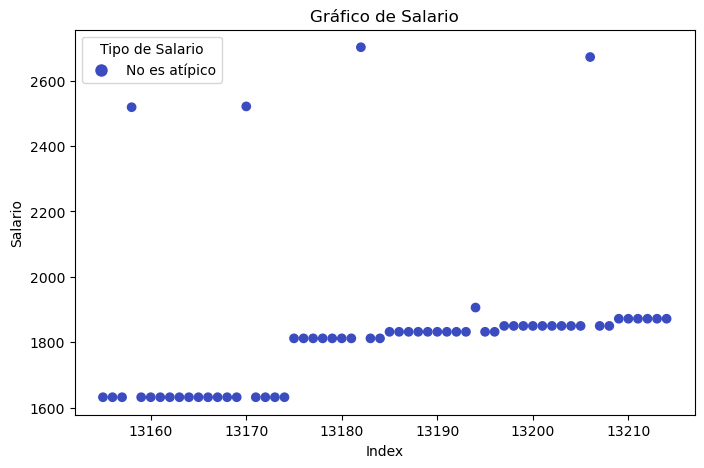

In [67]:
graf_ati(1908, 1)

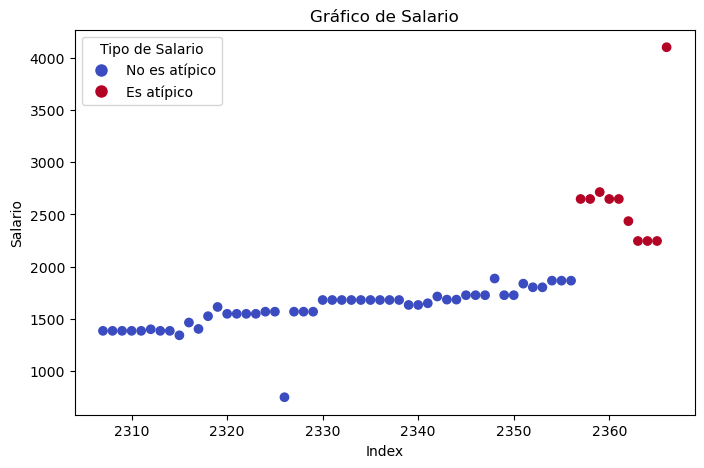

In [68]:
graf_ati(472, 1)

In [ ]:
#K-MEANS